In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pyod.models.gmm import GMM

normal_path = "features/S01/1/Normal/c_data"
relay_path  = "features/S01/1/Relay/c_data"

with h5py.File("datasets/features_S01_combined.h5", "r") as f:
    normal_group = f[normal_path]
    relay_group  = f[relay_path]

    n_norm = normal_group["0"].shape[0]
    n_relay = relay_group["0"].shape[0]

    dataset_normal = np.zeros((49997, n_norm))
    dataset_relay  = np.zeros((49998, n_relay))

    for i in range(49997):
        try:
            dataset_normal[i] = normal_group[str(i)][:]
        except KeyError:
            continue

    for i in range(49998):
        try:
            dataset_relay[i] = relay_group[str(i)][:]
        except KeyError:
            continue

scalerMinMax = MinMaxScaler()
scalerStandard = StandardScaler()

X_train               = dataset_normal[:47500]
X_test_normal         = dataset_normal[47500:]
X_test_relay          = dataset_relay[47500:]

scalerMinMax.fit(X_train)
X_train_scaled_minmax       = scalerMinMax.transform(X_train)
X_test_norm_scaled_minmax   = scalerMinMax.transform(X_test_normal)
X_test_relay_scaled_minmax  = scalerMinMax.transform(X_test_relay)

scalerStandard.fit(X_train)
X_train_scaled_standard        = scalerStandard.transform(X_train)
X_test_norm_scaled_standard    = scalerStandard.transform(X_test_normal)
X_test_relay_scaled_standard   = scalerStandard.transform(X_test_relay)

X_test_combined = np.vstack((X_test_normal, X_test_relay))
X_test_combined_scaled_minmax = np.vstack((X_test_norm_scaled_minmax, X_test_relay_scaled_minmax))
X_test_combined_scaled_standard = np.vstack((X_test_norm_scaled_standard, X_test_relay_scaled_standard))

y_true = np.array([0] * len(X_test_normal) + [1] * len(X_test_relay))


Classification Report:
               precision    recall  f1-score   support

      Normal       0.65      0.88      0.75      2497
       Relay       0.82      0.53      0.65      2498

    accuracy                           0.71      4995
   macro avg       0.74      0.71      0.70      4995
weighted avg       0.74      0.71      0.70      4995



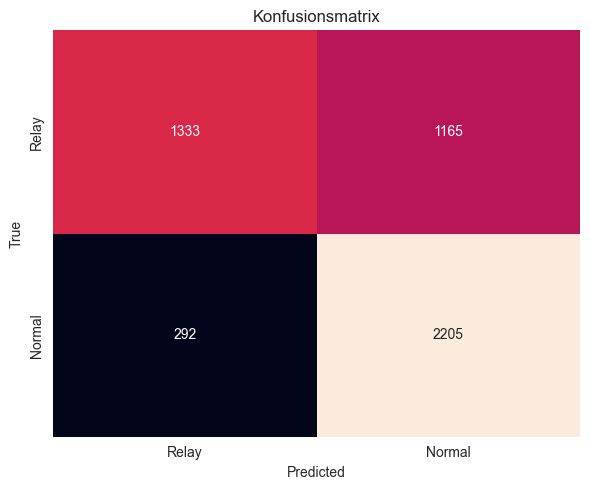

In [7]:

clf = GMM(contamination=0.1, covariance_type= 'full', init_params= 'random', max_iter= 200, n_components= 10, reg_covar= 1e-06)
clf.fit(X_train)

# pyod.predict: 0 = inlier, 1 = outlier
y_pred = clf.predict(X_test_combined)

# cm und report
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

# plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Relay","Normal"],
            yticklabels=["Relay","Normal"],
            cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Konfusionsmatrix")
plt.tight_layout()
plt.show()


Classification Report:
               precision    recall  f1-score   support

      Normal       0.72      0.90      0.80      2497
       Relay       0.87      0.65      0.75      2498

    accuracy                           0.78      4995
   macro avg       0.80      0.78      0.78      4995
weighted avg       0.80      0.78      0.78      4995



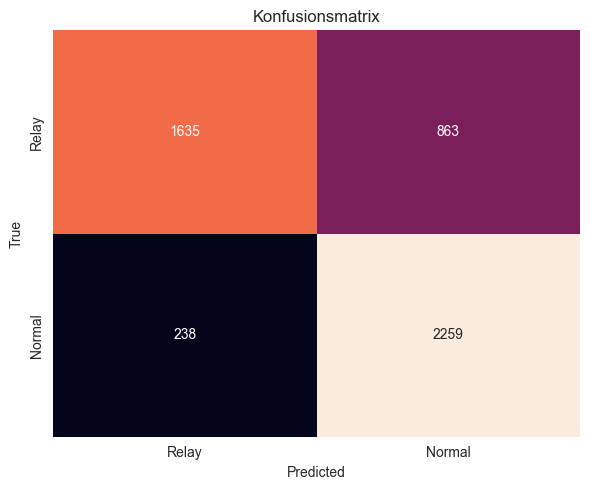

In [3]:

clf = GMM(contamination=0.01, n_components=80, max_iter=1000)
clf.fit(X_train)

# pyod.predict: 0 = inlier, 1 = outlier
y_pred = clf.predict(X_test_combined)

# cm und report
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

# plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Relay","Normal"],
            yticklabels=["Relay","Normal"],
            cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Konfusionsmatrix")
plt.tight_layout()
plt.show()

components 1

Classification Report:
               precision    recall  f1-score   support

      Normal       0.56      0.99      0.71      2497
       Relay       0.95      0.23      0.36      2498

    accuracy                           0.61      4995
   macro avg       0.75      0.61      0.54      4995
weighted avg       0.75      0.61      0.54      4995



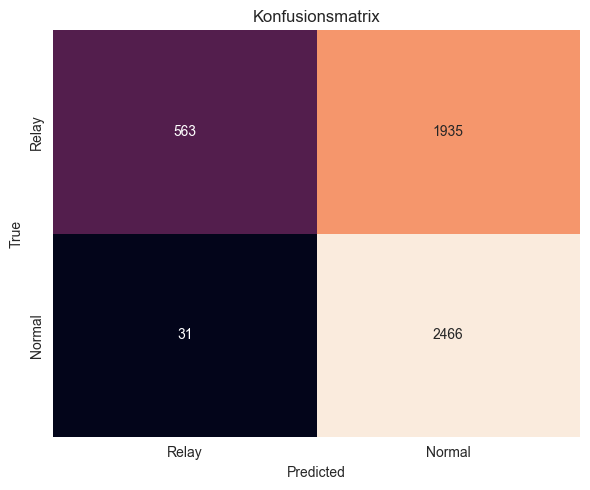

components 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.55      0.99      0.70      2497
       Relay       0.94      0.18      0.30      2498

    accuracy                           0.58      4995
   macro avg       0.74      0.58      0.50      4995
weighted avg       0.74      0.58      0.50      4995



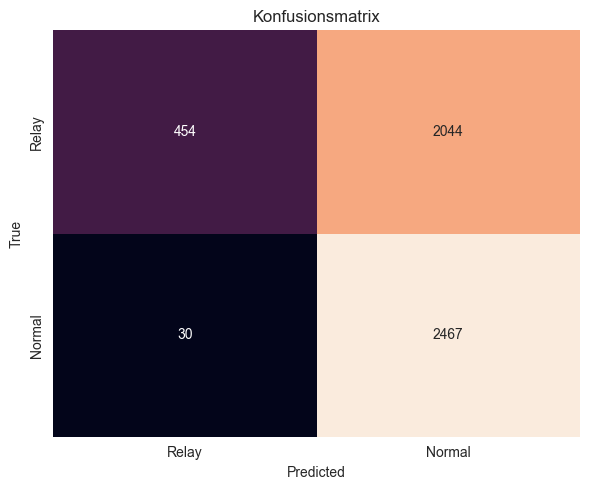

components 5

Classification Report:
               precision    recall  f1-score   support

      Normal       0.54      0.99      0.70      2497
       Relay       0.93      0.16      0.27      2498

    accuracy                           0.57      4995
   macro avg       0.74      0.57      0.48      4995
weighted avg       0.74      0.57      0.48      4995



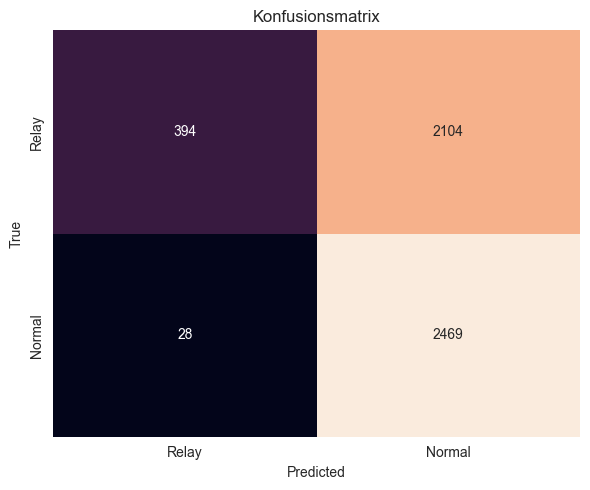

components 30

Classification Report:
               precision    recall  f1-score   support

      Normal       0.58      0.98      0.73      2497
       Relay       0.93      0.29      0.45      2498

    accuracy                           0.64      4995
   macro avg       0.76      0.64      0.59      4995
weighted avg       0.76      0.64      0.59      4995



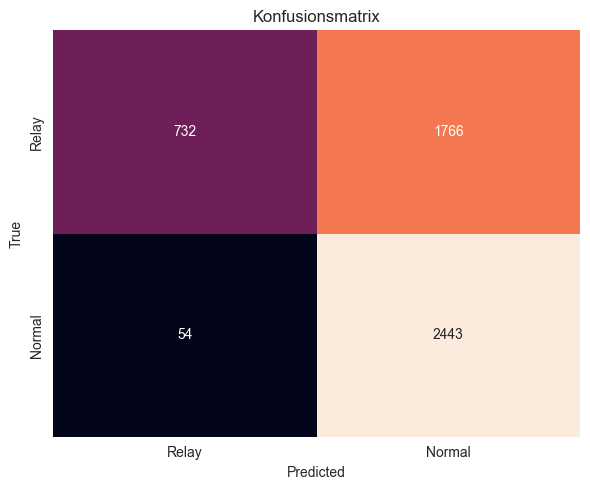

In [3]:
for n in {1,5,10,30}:
    clf = GMM(contamination=0.01, n_components=n)
    clf.fit(X_train_scaled_standard)

    # pyod.predict: 0 = inlier, 1 = outlier
    y_pred = clf.predict(X_test_combined_scaled_standard)

    # cm und report
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    print(f"components {n}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

    # plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=["Relay","Normal"],
                yticklabels=["Relay","Normal"],
                cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Konfusionsmatrix")
    plt.tight_layout()
    plt.show()

components 1

Classification Report:
               precision    recall  f1-score   support

      Normal       0.56      0.99      0.71      2497
       Relay       0.95      0.21      0.35      2498

    accuracy                           0.60      4995
   macro avg       0.75      0.60      0.53      4995
weighted avg       0.75      0.60      0.53      4995



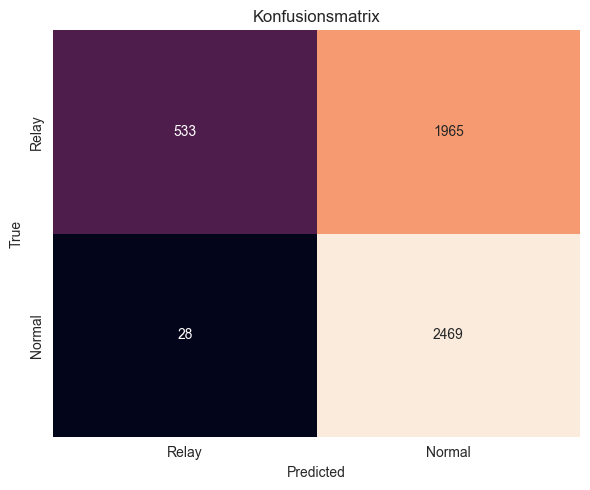

components 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.54      0.99      0.70      2497
       Relay       0.92      0.16      0.27      2498

    accuracy                           0.57      4995
   macro avg       0.73      0.57      0.49      4995
weighted avg       0.73      0.57      0.49      4995



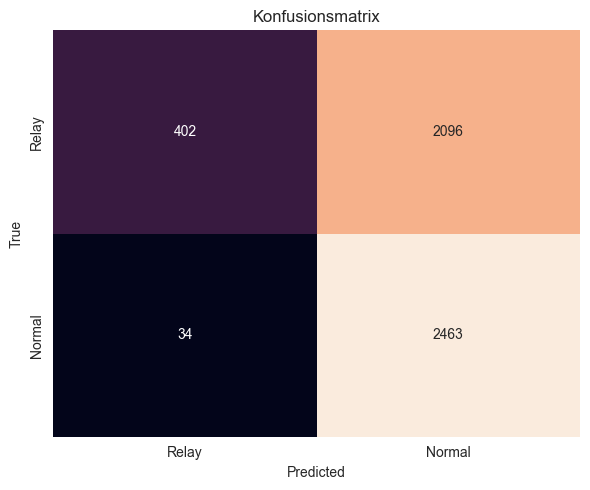

components 5

Classification Report:
               precision    recall  f1-score   support

      Normal       0.53      0.99      0.69      2497
       Relay       0.92      0.13      0.22      2498

    accuracy                           0.56      4995
   macro avg       0.72      0.56      0.46      4995
weighted avg       0.72      0.56      0.46      4995



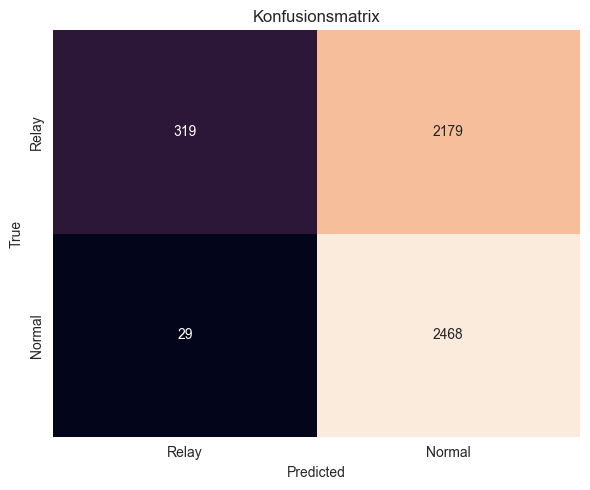

components 30

Classification Report:
               precision    recall  f1-score   support

      Normal       0.55      0.98      0.71      2497
       Relay       0.93      0.21      0.34      2498

    accuracy                           0.60      4995
   macro avg       0.74      0.60      0.53      4995
weighted avg       0.74      0.60      0.53      4995



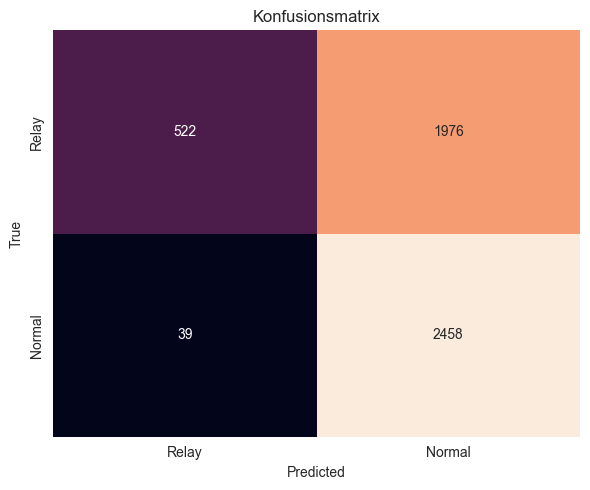

In [4]:
param_grid = [{
    "n_components": [1, 2, 3, 5, 10],
    "covariance_type": ["full", "tied", "diag", "spherical"],
    "reg_covar": [1e-6, 1e-4],
    "init_params": ["kmeans", "random"],
    "max_iter": [100, 200]
}]

for n in {1,5,10,30}:
    clf = GMM(contamination=0.01, n_components=n)
    clf.fit(X_train_scaled_minmax)

    # pyod.predict: 0 = inlier, 1 = outlier
    y_pred = clf.predict(X_test_combined_scaled_minmax)

    # cm und report
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    print(f"components {n}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

    # plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=["Relay","Normal"],
                yticklabels=["Relay","Normal"],
                cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Konfusionsmatrix")
    plt.tight_layout()
    plt.show()

In [2]:
param_grid = [{
    "n_components": [60, 70, 80, 90],
    "covariance_type": ["full"],
    "reg_covar": [1e-4],
    "init_params": ["kmeans", "random"],
    "max_iter": [200],
    "contamination": [0.03, 0.05, 0.1, 0.15],
    "random_state": [42]
}]

best_acc = 0
best_params = None

for params in ParameterGrid(param_grid[0]):
    clf = GMM(**params)
    clf.fit(X_train)

    y_pred = clf.predict(X_test_combined)

    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}  → Params: {params}")

    if acc > best_acc:
        best_acc = acc
        best_params = params

print("\nBeste Parameterkombination:", best_params)
print(f"Beste Accuracy: {best_acc:.4f}")

KeyboardInterrupt: 